In [18]:
import os
from pathlib import Path
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

try:
    import cupy as cp
    if cp.cuda.is_available():
        print("GPU is available")
        print("GPU:", cp.cuda.runtime.getDeviceProperties(0)["name"])
    else:
        print("CuPy installed but no GPU detected")
except Exception as e:
    print(f"GPU not available: {e}")
    print("Running on CPU only")

from IPython.display import HTML, display
import h5py
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

plt.rcParams["figure.figsize"] = (5, 4)
tempdir = tempfile.TemporaryDirectory()



GPU is available
GPU: b'NVIDIA GeForce GTX 1050 Ti'


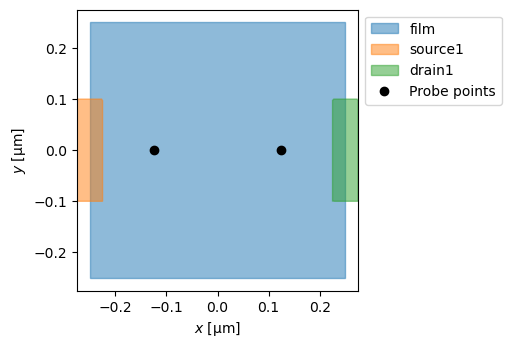

In [2]:
physical_params = {
    "length_units": "um",
    "xi": 0.1,
    "london_lambda": 2,
    "thickness": 0.1,
    "gamma": 1,
    "width": 0.5,
    "height": 0.5,
    "terminal_size": (0.05, 0.2),
}

layer = tdgl.Layer(
    coherence_length=physical_params["xi"],
    london_lambda=physical_params["london_lambda"],
    thickness=physical_params["thickness"],
    gamma=physical_params["gamma"],
)

film = tdgl.Polygon(
    "film",
    points=box(physical_params["width"], physical_params["height"]),
).resample(401).buffer(0)

term_width, term_height = physical_params["terminal_size"]
source1 = (
    tdgl.Polygon("source1", points=box(term_width, term_height))
    .translate(-physical_params["width"] / 2, 0)
    .buffer(0)
)
drain1 = (
    tdgl.Polygon("drain1", points=box(term_width, term_height))
    .translate(physical_params["width"] / 2, 0)
    .buffer(0)
)

probe_points = [
    ((-physical_params["width"] * 0.25, 0.0), (physical_params["width"] * 0.25, 0.0))
]

device = tdgl.Device(
    "2currents",
    layer=layer,
    film=film,
    terminals=[source1, drain1],
    length_units=physical_params["length_units"],
    probe_points=probe_points,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 2226/2226 [00:01<00:00, 1465.63it/s]


num_sites,2226
num_elements,4050
min_edge_length,3.027e-03
max_edge_length,2.472e-02
mean_edge_length,1.092e-02
min_area,5.575e-06
max_area,3.604e-04
mean_area,1.123e-04
coherence_length,1.000e-01
length_units,um


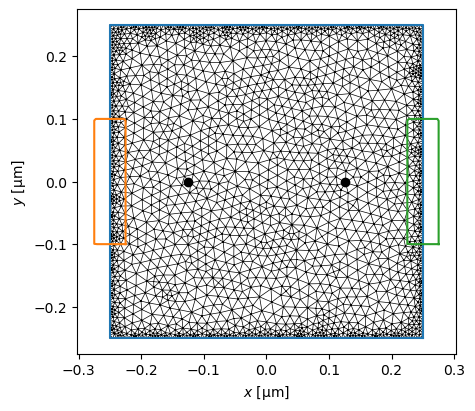

In [3]:
device.make_mesh(max_edge_length=physical_params["xi"] / 4, smooth=100)
display(device.mesh_stats())
fig, ax = device.plot(mesh=True, legend=False)

Sweep config

In [4]:
H_FIELD_VALUES = np.round(np.linspace(0, 20, 10), 3)
CURRENT_VALUES = np.round(np.linspace(0, 20, 100), 3)

project_root = Path("..").resolve()
datasets_candidate = project_root / "datastest"
if datasets_candidate.is_dir():
    DATASETS_ROOT = datasets_candidate
else:
    DATASETS_ROOT = (project_root / "datasets")
DATASETS_ROOT.mkdir(parents=True, exist_ok=True)

sweep_root = DATASETS_ROOT / "H_sweep_nogap"
sweep_root.mkdir(exist_ok=True)

options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "h-nogap-current.h5"),
    field_units="mT",
    current_units="uA",
)

all_voltage_traces = []  # shape: [H][current][time]
all_time_traces = []
steady_state_voltages = []  # [H][current]

# Garantiza que el dispositivo tenga malla antes de llamar al solver
if getattr(device, "mesh", None) is None:
    device.make_mesh(max_edge_length=physical_params["xi"] / 4, smooth=100)

RUN_SWEEP = False  # ponlo en True solo si necesitas recalcular todo el barrido

if RUN_SWEEP:
    for h_index, h_value in enumerate(H_FIELD_VALUES):
        h_dir = sweep_root / f"H_{h_value:05.2f}mT"
        h_dir.mkdir(exist_ok=True)
        h_voltages = []
        h_times = []
        h_steady = []
        applied_vector_potential = tdgl.sources.constant.ConstantField(
            h_value, field_units=options.field_units, length_units=device.length_units
        )
        for cur_index, bias in enumerate(CURRENT_VALUES):
            save_path = h_dir / f"bias_{cur_index:04d}.npz"
            if save_path.exists():
                cached = np.load(save_path)
                voltage_trace = cached["voltage"]
                time_trace = cached["time"]
            else:
                sweep_solution = tdgl.solve(
                    device=device,
                    options=options,
                    applied_vector_potential=applied_vector_potential,
                    terminal_currents=dict(source1=bias, drain1=-bias),
                )
                voltage_trace = sweep_solution.dynamics.voltage()
                time_trace = sweep_solution.dynamics.time
                np.savez_compressed(
                    save_path,
                    current=bias,
                    time=time_trace,
                    voltage=voltage_trace,
                )
            h_voltages.append(voltage_trace)
            h_times.append(time_trace)
            tail_start = int(0.5 * len(voltage_trace))
            steady_value = float(np.mean(voltage_trace[tail_start:]))
            h_steady.append(steady_value)
        all_voltage_traces.append(h_voltages)
        all_time_traces.append(h_times)
        steady_state_voltages.append(h_steady)
else:
    print("RUN_SWEEP=False → se omite la simulación; usa la celda de carga para leer el cache existente.")

RUN_SWEEP=False → se omite la simulación; usa la celda de carga para leer el cache existente.


In [5]:
MAX_PLOT_FIELDS = 10  # límite para no saturar las gráficas
MATCH_TOL = 5e-3     # tolerancia al comparar nombres de carpetas vs H_FIELD_VALUES

available_dirs = sorted(sweep_root.glob("H_*mT"))
if not available_dirs:
    raise ValueError(f"No se encontraron subdirectorios H_*mT en {sweep_root}.")

plot_h_indices = []
plot_h_values = []
for dir_path in available_dirs:
    name = dir_path.name
    try:
        h_str = name.split("H_")[1].replace("mT", "")
        h_value = float(h_str)
    except (IndexError, ValueError):
        continue
    matches = np.where(np.isclose(H_FIELD_VALUES, h_value, atol=MATCH_TOL))[0]
    if matches.size == 0:
        continue
    idx = int(matches[0])
    if idx in plot_h_indices:
        continue
    plot_h_indices.append(idx)
    plot_h_values.append(H_FIELD_VALUES[idx])
    if len(plot_h_indices) == MAX_PLOT_FIELDS:
        break

if not plot_h_indices:
    raise ValueError(
        "No fue posible asociar las carpetas detectadas con los valores definidos en H_FIELD_VALUES."
    )

print(f"Campos detectados: {plot_h_values}")

all_voltage_traces = [None] * len(H_FIELD_VALUES)
all_time_traces = [None] * len(H_FIELD_VALUES)
steady_state_voltages = [None] * len(H_FIELD_VALUES)

for h_idx, h_value in zip(plot_h_indices, plot_h_values):
    h_dir = sweep_root / f"H_{h_value:05.2f}mT"
    if not h_dir.exists():
        print(f"Directorio faltante para H = {h_value:.2f} mT ({h_dir})")
        continue

    h_voltages = []
    h_times = []
    h_steady = []
    missing = []

    for cur_index, bias in enumerate(CURRENT_VALUES):
        save_path = h_dir / f"bias_{cur_index:04d}.npz"
        if not save_path.exists():
            missing.append(cur_index)
            continue

        cached = np.load(save_path)
        voltage_trace = cached["voltage"]
        time_trace = cached["time"]
        h_voltages.append(voltage_trace)
        h_times.append(time_trace)

        tail_start = int(0.5 * len(voltage_trace))
        steady_value = float(np.mean(voltage_trace[tail_start:]))
        h_steady.append(steady_value)

    all_voltage_traces[h_idx] = h_voltages
    all_time_traces[h_idx] = h_times
    steady_state_voltages[h_idx] = h_steady

    if missing:
        sample = ", ".join(str(m) for m in missing[:5])
        print(
            f"H = {h_value:.2f} mT: faltan {len(missing)} corrientes (ej: {sample}); se cargaron {len(h_voltages)} curvas"
        )
    else:
        print(f"H = {h_value:.2f} mT: {len(h_voltages)} corrientes recuperadas del cache")

print("Carga desde cache completada. Ahora puedes ejecutar las celdas de gráficas y análisis.")

Campos detectados: [np.float64(0.0), np.float64(2.222), np.float64(4.444), np.float64(6.667), np.float64(8.889), np.float64(11.111)]
H = 0.00 mT: 100 corrientes recuperadas del cache
H = 0.00 mT: 100 corrientes recuperadas del cache
H = 2.22 mT: 100 corrientes recuperadas del cache
H = 2.22 mT: 100 corrientes recuperadas del cache
H = 4.44 mT: 100 corrientes recuperadas del cache
H = 4.44 mT: 100 corrientes recuperadas del cache
H = 6.67 mT: 100 corrientes recuperadas del cache
H = 6.67 mT: 100 corrientes recuperadas del cache
H = 8.89 mT: 100 corrientes recuperadas del cache
H = 8.89 mT: 100 corrientes recuperadas del cache
H = 11.11 mT: 100 corrientes recuperadas del cache
Carga desde cache completada. Ahora puedes ejecutar las celdas de gráficas y análisis.
H = 11.11 mT: 100 corrientes recuperadas del cache
Carga desde cache completada. Ahora puedes ejecutar las celdas de gráficas y análisis.


Sin trazas almacenadas para H = 13.33 mT.
Sin trazas almacenadas para H = 15.56 mT.
Sin trazas almacenadas para H = 17.78 mT.
Sin trazas almacenadas para H = 20.00 mT.


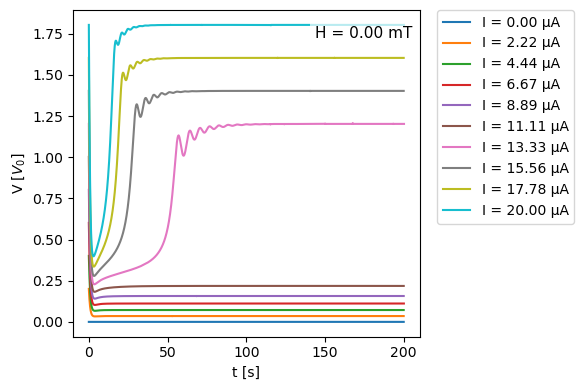

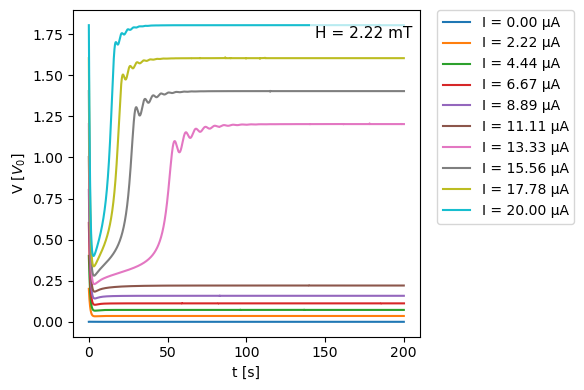

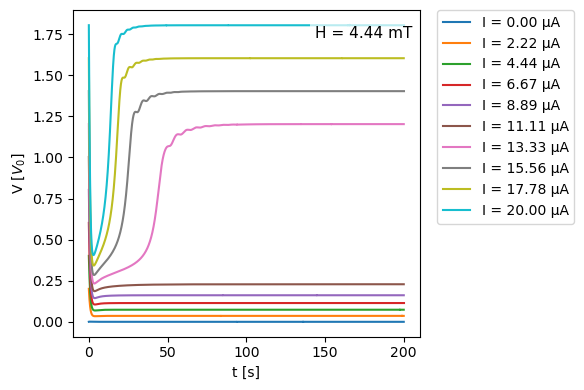

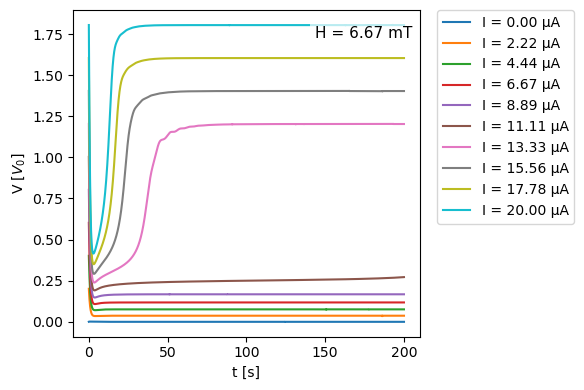

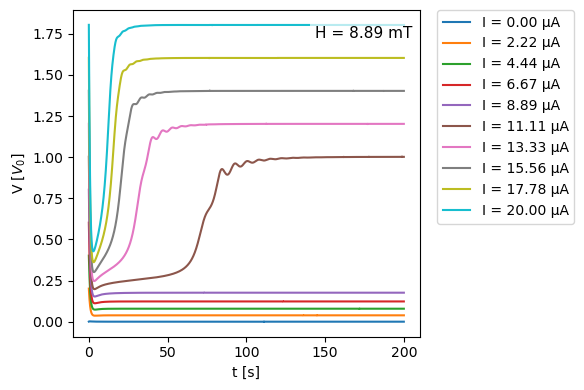

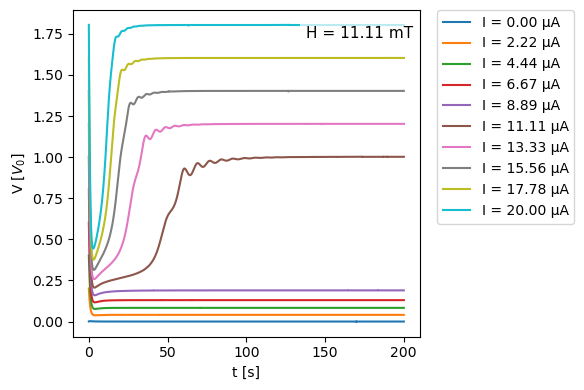

In [6]:
currents_per_plot = 10
sample_indices = np.linspace(0, len(CURRENT_VALUES) - 1, currents_per_plot, dtype=int)

for h_idx, h_value in enumerate(H_FIELD_VALUES):
    if h_idx >= len(all_time_traces) or h_idx >= len(all_voltage_traces):
        print(f"No hay datos para H = {h_value:.2f} mT (índice {h_idx}).")
        continue

    h_time_traces = all_time_traces[h_idx]
    h_voltage_traces = all_voltage_traces[h_idx]

    if not h_time_traces or not h_voltage_traces:
        print(f"Sin trazas almacenadas para H = {h_value:.2f} mT.")
        continue

    plt.figure(figsize=(6, 4))
    for idx in sample_indices:
        if idx >= len(h_time_traces) or idx >= len(h_voltage_traces):
            continue
        ttrace = h_time_traces[idx]
        vtrace = h_voltage_traces[idx]
        label_current = CURRENT_VALUES[idx]
        plt.plot(ttrace, vtrace, label=f"I = {label_current:.2f} \u03bcA")

    plt.xlabel("t [s]")
    plt.ylabel("V [$V_0$]")
    #plt.title(f"Voltaje vs tiempo para H = {h_value:.2f} mT")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.text(
        0.98,
        0.95,
        f"H = {h_value:.2f} mT",
        transform=plt.gca().transAxes,
        ha="right",
        va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )
    plt.tight_layout()

plt.show()

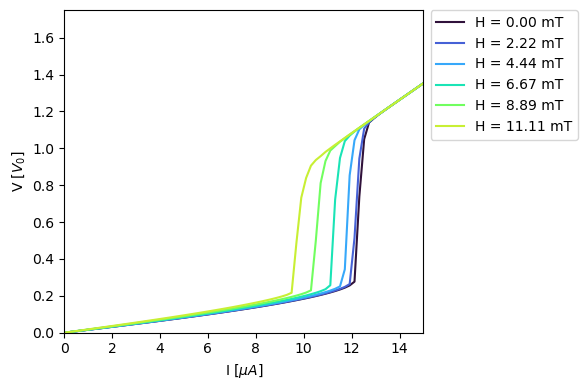

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
max_H = np.max(H_FIELD_VALUES)
plotted = 0
for h_index, h_value in enumerate(H_FIELD_VALUES):
    volt_curve = steady_state_voltages[h_index] if h_index < len(steady_state_voltages) else None
    if not volt_curve:
        continue
    volt_curve = np.asarray(volt_curve, dtype=float)
    if volt_curve.size == 0:
        continue
    plotted += 1
    ax.plot(CURRENT_VALUES[: volt_curve.size], volt_curve, label=f"H = {h_value:.2f} mT", c=cm.turbo(h_value / max_H))

if plotted == 0:
    raise RuntimeError("No hay curvas cargadas en steady_state_voltages; ejecuta la celda de carga primero.")

sm = plt.cm.ScalarMappable(cmap=cm.turbo, norm=plt.Normalize(vmin=np.min(H_FIELD_VALUES), vmax=max_H))
sm.set_array([])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
ax.set_xlabel("I [$\mu A$]")
ax.set_ylabel("V [$V_0$]")
ax.set_xlim(0, 15)
ax.set_ylim(0, 1.75)
# ax.set_title("Curvas I-V por campo magnético")
plt.tight_layout()

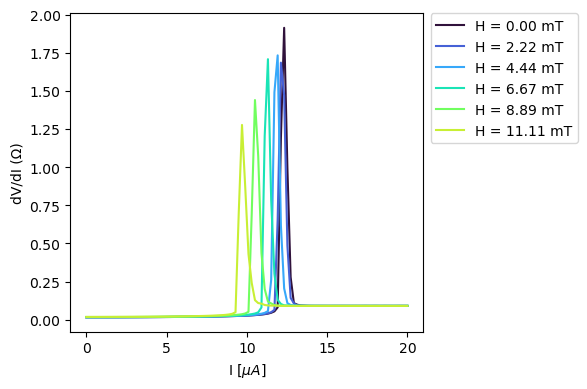

In [8]:
resistance_curves = []  # dV/dI para cada campo
plt.figure(figsize=(6, 4))
max_h = float(np.max(H_FIELD_VALUES)) if len(H_FIELD_VALUES) else 1.0
for h_index, h_value in enumerate(H_FIELD_VALUES):
    volt_curve = steady_state_voltages[h_index] if h_index < len(steady_state_voltages) else None
    if not volt_curve:
        continue
    volt_curve = np.asarray(volt_curve, dtype=float)
    if volt_curve.size < 2:
        continue
    current_axis = np.asarray(CURRENT_VALUES[: volt_curve.size], dtype=float)
    dv_di = np.gradient(volt_curve, current_axis)
    resistance_curves.append((h_value, dv_di))
    color_norm = h_value / max_h if max_h else 0.0
    plt.plot(
        current_axis,
        dv_di,
        label=f"H = {h_value:.2f} mT",
        c=cm.turbo(color_norm),
    )
plt.xlabel("I [$\mu A$]")
plt.ylabel("dV/dI (Ω)")
# plt.title("Resistencia (dV/dI) vs corriente para cada H (gap)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

H =  0.00 mT -> J1 ≈  1.26 μA
H =  2.22 mT -> J1 ≈  1.26 μA
H =  4.44 mT -> J1 ≈  1.24 μA
H =  6.67 mT -> J1 ≈  1.20 μA
H =  8.89 mT -> J1 ≈  1.16 μA
H = 11.11 mT -> J1 ≈  1.10 μA
H = 13.33 mT -> J1 ≈   nan μA
H = 15.56 mT -> J1 ≈   nan μA
H = 17.78 mT -> J1 ≈   nan μA
H = 20.00 mT -> J1 ≈   nan μA


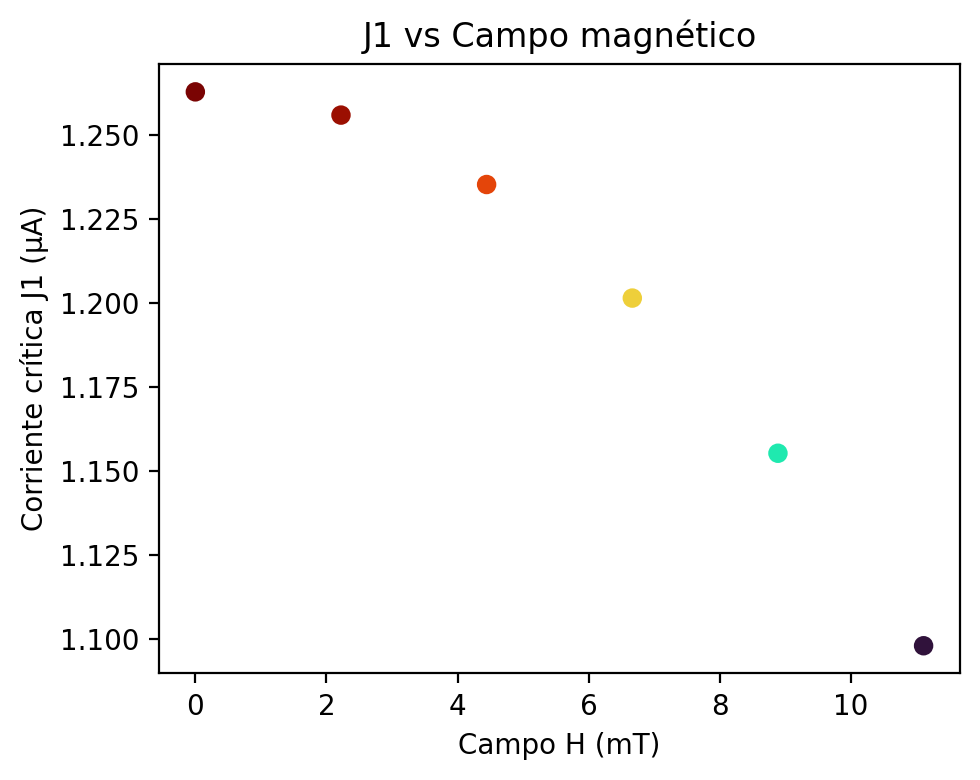

In [9]:
def estimate_j1(currents, voltages, threshold=0.02):
    currents = np.asarray(currents, dtype=float)
    voltages = np.asarray(voltages, dtype=float)
    if currents.size == 0 or voltages.size == 0:
        return np.nan
    if currents.size != voltages.size:
        min_size = min(currents.size, voltages.size)
        currents = currents[:min_size]
        voltages = voltages[:min_size]

    valid = np.isfinite(currents) & np.isfinite(voltages)
    if not np.any(valid):
        return np.nan
    currents = currents[valid]
    voltages = voltages[valid]
    if len(currents) < 2:
        return np.nan

    above = np.where(voltages >= threshold)[0]
    if len(above) == 0:
        return np.nan

    idx = above[0]
    if idx == 0:
        return currents[0]

    i0, i1 = currents[idx - 1], currents[idx]
    v0, v1 = voltages[idx - 1], voltages[idx]
    if v1 == v0:
        return i1
    return np.interp(threshold, [v0, v1], [i0, i1])

threshold_voltage = 0.02  # ajusta si quieres detectar el salto un poco más arriba/abajo
critical_currents = []
for h_index, h_value in enumerate(H_FIELD_VALUES):
    volt_curve = steady_state_voltages[h_index] if h_index < len(steady_state_voltages) else None
    if not volt_curve:
        critical_currents.append(np.nan)
        continue
    volt_curve = np.asarray(volt_curve, dtype=float)
    if volt_curve.ndim == 0 or volt_curve.size < 2:
        critical_currents.append(np.nan)
        continue
    current_axis = np.asarray(CURRENT_VALUES[: volt_curve.size], dtype=float)
    crit_val = estimate_j1(current_axis, volt_curve, threshold=threshold_voltage)
    critical_currents.append(crit_val)

critical_currents = np.array(critical_currents)

plt.figure(figsize=(5, 4), dpi=200)
plt.scatter(H_FIELD_VALUES, critical_currents, c=critical_currents, cmap=cm.turbo)
#plt.plot(H_FIELD_VALUES, critical_currents, color="firebrick", linewidth=1.0)
plt.xlabel("Campo H (mT)")
plt.ylabel("Corriente crítica J1 (\u03bcA)")
plt.title(f"J1 vs Campo magnético")
plt.tight_layout()

for h_value, j1 in zip(H_FIELD_VALUES, critical_currents):
    print(f"H = {h_value:5.2f} mT -> J1 ≈ {j1:5.2f} \u03bcA")

J1(H) ≈ -0.0013 H^2 + -0.0007 H + 1.2633


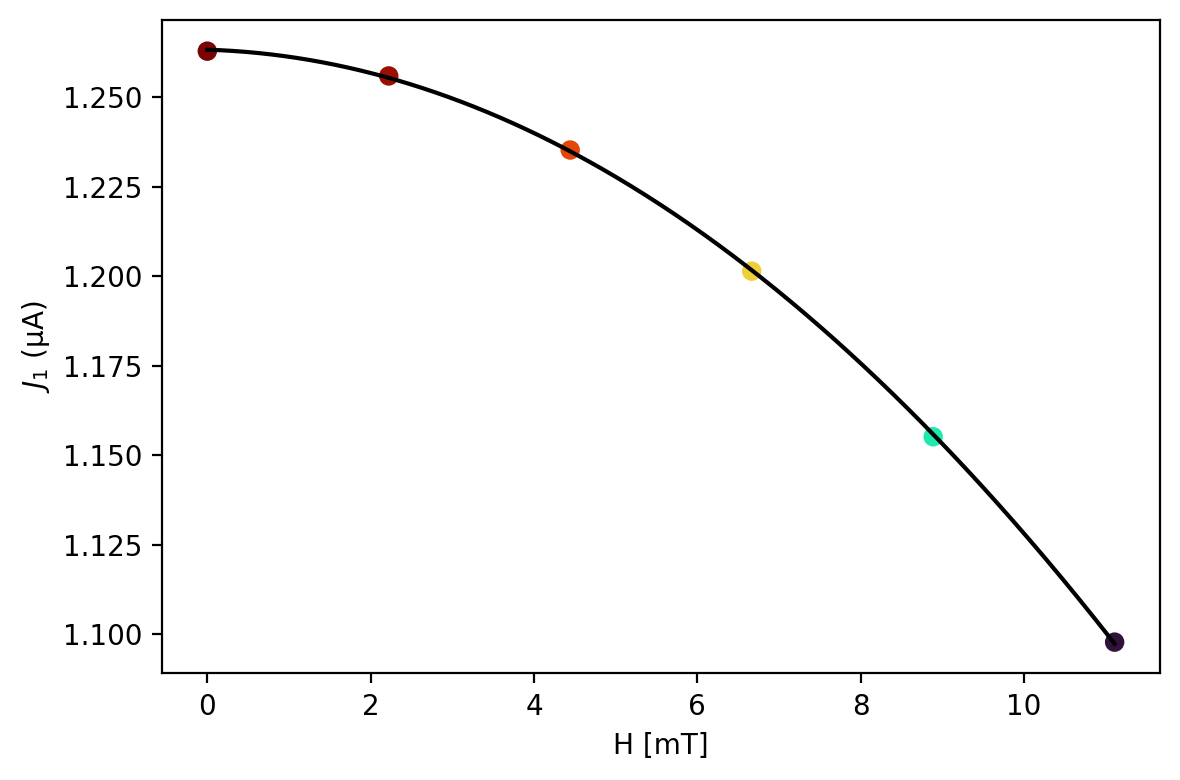

In [10]:
valid_mask = globals().get("critical_currents", None)
if valid_mask is None:
    try:
        estimate_func = estimate_j1
    except NameError:
        def estimate_func(currents, voltages, threshold=0.02):
            currents = np.asarray(currents, dtype=float)
            voltages = np.asarray(voltages, dtype=float)
            valid = np.isfinite(currents) & np.isfinite(voltages)
            currents = currents[valid]
            voltages = voltages[valid]
            if len(currents) < 2:
                return np.nan
            above = np.where(voltages >= threshold)[0]
            if len(above) == 0:
                return np.nan
            idx = above[0]
            if idx == 0:
                return currents[0]
            i0, i1 = currents[idx - 1], currents[idx]
            v0, v1 = voltages[idx - 1], voltages[idx]
            if v1 == v0:
                return i1
            return np.interp(threshold, [v0, v1], [i0, i1])
    critical_currents = []
    for h_index, _ in enumerate(H_FIELD_VALUES):
        volt_curve = steady_state_voltages[h_index]
        critical_currents.append(
            estimate_func(CURRENT_VALUES, volt_curve, threshold=0.02)
        )
    critical_currents = np.asarray(critical_currents, dtype=float)
else:
    critical_currents = np.asarray(critical_currents, dtype=float)

valid_mask = np.isfinite(critical_currents)
if np.count_nonzero(valid_mask) < 3:
    print("No hay suficientes puntos válidos para ajustar.")
else:
    h_valid = np.asarray(H_FIELD_VALUES)[valid_mask]
    j_valid = np.asarray(critical_currents)[valid_mask]
    quad_coeffs = np.polyfit(h_valid, j_valid, 2)
    quad_poly = np.poly1d(quad_coeffs)

    h_dense = np.linspace(h_valid.min(), h_valid.max(), 500)
    j_fit = quad_poly(h_dense)

    plt.figure(figsize=(6, 4), dpi=200)
    plt.scatter(h_valid, j_valid, c=j_valid, cmap=cm.turbo,)
    plt.plot(h_dense, j_fit, color="black", linewidth=1.5, )
    plt.xlabel("H [mT]")
    plt.ylabel("$J_1$ (\u03bcA)")
    # plt.title("J1(H) con ajuste cuadrático (gap)")
    # plt.legend()
    plt.tight_layout()

    a, b, c = quad_coeffs
    print(f"J1(H) ≈ {a:.4f} H^2 + {b:.4f} H + {c:.4f}")

In [11]:
target_current = 8.0  # μA solicitada
num_h_fields = len(H_FIELD_VALUES)
closest_idx = int(np.abs(CURRENT_VALUES - target_current).argmin())
closest_current = float(CURRENT_VALUES[closest_idx])
needs_exact_run = not np.isclose(closest_current, target_current, atol=1e-6)
simulaciones_nuevas = num_h_fields if needs_exact_run else 0
mensaje = (
    f"Con {num_h_fields} campos H y una sola corriente fija se requieren "
    f"{simulaciones_nuevas} simulaciones nuevas para I = {target_current:.2f} μA."
    if needs_exact_run
    else
    f"La malla de corrientes ya incluye {target_current:.2f} μA (índice {closest_idx}), "
    f"así que no necesitas ejecuciones adicionales."
)
print(mensaje)
print(
    f"La corriente más cercana en la malla actual es {closest_current:.3f} μA (índice {closest_idx})."
 )
if needs_exact_run:
    print(
        "Recomendación: re-ejecutar solo esos "
        f"{num_h_fields} casos almacenando |Ψ|² y Δφ tras alcanzar el régimen estacionario."
    )

Con 10 campos H y una sola corriente fija se requieren 10 simulaciones nuevas para I = 8.00 μA.
La corriente más cercana en la malla actual es 8.081 μA (índice 40).
Recomendación: re-ejecutar solo esos 10 casos almacenando |Ψ|² y Δφ tras alcanzar el régimen estacionario.


In [16]:
import pandas as pd

order_phase_dir = Path("H_nogap_order_phase")
order_phase_dir.mkdir(exist_ok=True)

mesh = device.mesh
mesh_coords = None
for attr in ("points", "sites", "vertices", "coordinates"):
    if hasattr(mesh, attr):
        candidate = getattr(mesh, attr)
        candidate = candidate() if callable(candidate) else candidate
        arr = np.asarray(candidate)
        if arr.ndim >= 2 and arr.shape[1] >= 2:
            mesh_coords = arr
            break

if mesh_coords is None:
    raise AttributeError(
        "device.mesh no expone puntos accesibles; revisa las propiedades disponibles para coordenadas."
    )

x_coords = mesh_coords[:, 0]
y_coords = mesh_coords[:, 1]
hole_center = np.array(physical_params.get("hole_center", (0.0, 0.0)), dtype=float)
hole_radius = float(physical_params.get("hole_radius", 0.0))
has_hole = hole_radius > 0.0

distance_to_hole = np.hypot(x_coords - hole_center[0], y_coords - hole_center[1])
if has_hole:
    in_hole_mask = distance_to_hole <= hole_radius
else:
    in_hole_mask = np.zeros_like(distance_to_hole, dtype=bool)

left_mask = x_coords < -0.05
right_mask = x_coords > 0.05

for name, mask in (("left", left_mask), ("right", right_mask)):
    if not np.any(mask):
        raise RuntimeError(f"La máscara {name} no contiene nodos; revisa los umbrales.")

    if has_hole and np.any(mask & in_hole_mask):
        raise RuntimeError(
            f"La máscara {name} incluye nodos dentro del hueco; ajusta los límites antes de continuar.",
        )

    pts = mesh_coords[mask]
    if has_hole:
        margin = np.min(distance_to_hole[mask]) - hole_radius
        print(
            f"Máscara {name}: {pts.shape[0]} nodos, margen mínimo respecto al borde del hueco = {margin:.4f} μm"
        )
    else:
        print(f"Máscara {name}: {pts.shape[0]} nodos (geometría sin hueco)")

order_phase_records = []
snapshot_field_data = {}

if "plot_h_values" in globals() and plot_h_values:
    h_targets = np.asarray(sorted(set(float(v) for v in plot_h_values)), dtype=float)
    print(f"Tomando {len(h_targets)} campos detectados desde el cache para los snapshots |Ψ|² y Δφ.")
else:
    h_targets = np.asarray(H_FIELD_VALUES, dtype=float)
    print("No se detectó lista filtrada; se usarán todos los valores declarados en H_FIELD_VALUES.")

for h_value in h_targets:
    cache_file = order_phase_dir / f"H_{h_value:05.2f}mT_order_phase.npz"
    if cache_file.exists():
        cached = np.load(cache_file, allow_pickle=True)
        record = {
            "H_mT": float(cached["H_mT"]),
            "current_uA": float(cached["current_uA"]),
            "density_mean": float(cached["density_mean"]),
            "delta_phi": float(cached["delta_phi"]),
        }
        order_phase_records.append(record)
        snapshot_field_data[float(h_value)] = {
            "x": x_coords,
            "y": y_coords,
            "density": np.asarray(cached["density"]),
            "phase": np.asarray(cached["phase"]),
            "delta_phi": record["delta_phi"],
            "mean_density": record["density_mean"],
        }
        continue

    applied_field = tdgl.sources.constant.ConstantField(
        h_value, field_units=options.field_units, length_units=device.length_units
    )
    sweep_solution = tdgl.solve(
        device=device,
        options=options,
        applied_vector_potential=applied_field,
        terminal_currents=dict(source1=target_current, drain1=-target_current),
    )

    tdgl_data = sweep_solution.tdgl_data
    if tdgl_data is None or tdgl_data.psi is None:
        raise RuntimeError("La simulación no devolvió datos TDGL con psi disponible.")

    psi_values = np.asarray(tdgl_data.psi)
    density = np.abs(psi_values) ** 2
    phase = np.angle(psi_values)

    left_phase = np.angle(np.mean(psi_values[left_mask]))
    right_phase = np.angle(np.mean(psi_values[right_mask]))
    phase_pair = np.unwrap([left_phase, right_phase])
    delta_phi = float(phase_pair[1] - phase_pair[0])

    record = {
        "H_mT": float(h_value),
        "current_uA": float(target_current),
        "density_mean": float(np.mean(density)),
        "delta_phi": delta_phi,
    }

    np.savez(
        cache_file,
        H_mT=record["H_mT"],
        current_uA=record["current_uA"],
        density_mean=record["density_mean"],
        delta_phi=record["delta_phi"],
        density=density,
        phase=phase,
        left_phase=left_phase,
        right_phase=right_phase,
    )
    order_phase_records.append(record)
    snapshot_field_data[float(h_value)] = {
        "x": x_coords,
        "y": y_coords,
        "density": density,
        "phase": phase,
        "delta_phi": delta_phi,
        "mean_density": record["density_mean"],
    }

order_phase_df = pd.DataFrame(order_phase_records).sort_values("H_mT")
display(order_phase_df)


Máscara left: 1101 nodos (geometría sin hueco)
Máscara right: 1094 nodos (geometría sin hueco)
Tomando 6 campos detectados desde el cache para los snapshots |Ψ|² y Δφ.


,H_mT,current_uA,density_mean,delta_phi
0,0.000,8.0,0.596511,0.648572
1,2.222,8.0,0.593306,0.652185
2,4.444,8.0,0.584019,0.664400
3,6.667,8.0,0.568475,0.687221
4,8.889,8.0,0.546386,0.723281
5,11.111,8.0,0.516762,0.779735


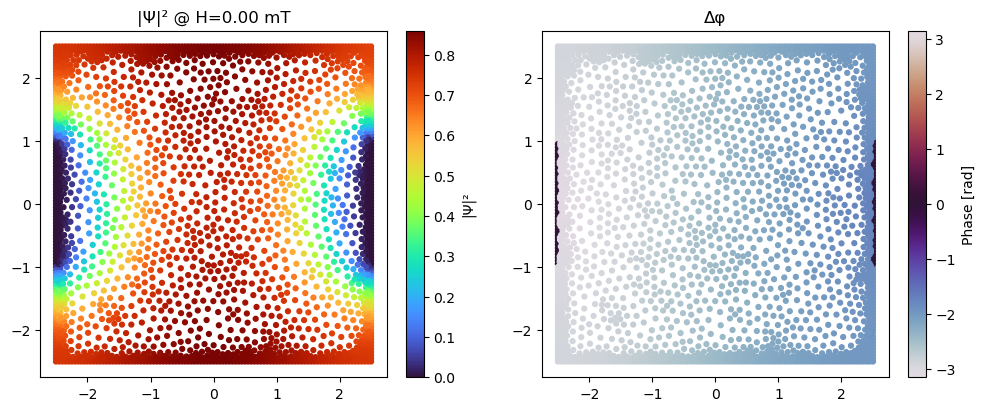

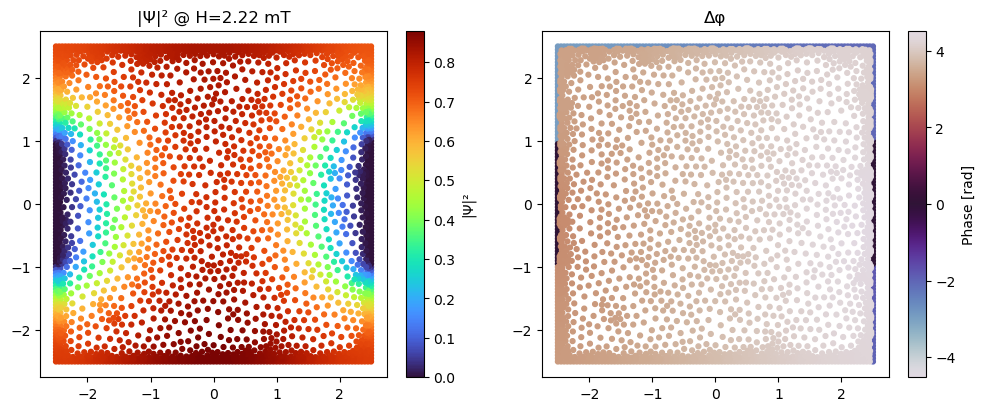

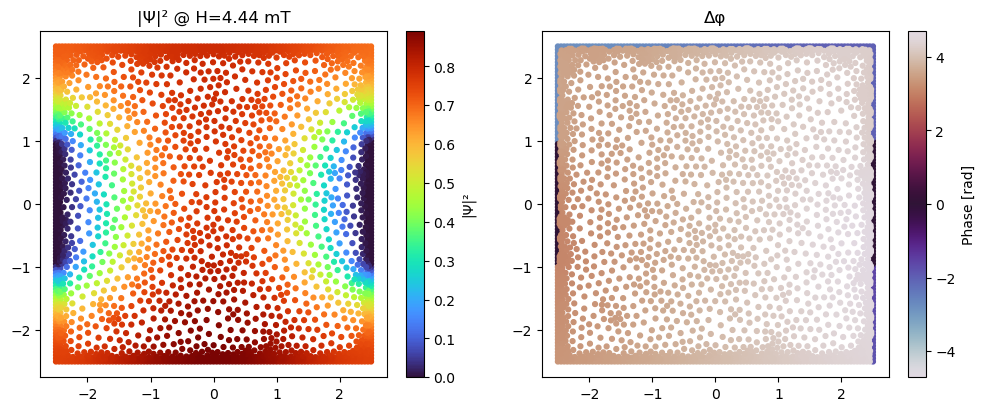

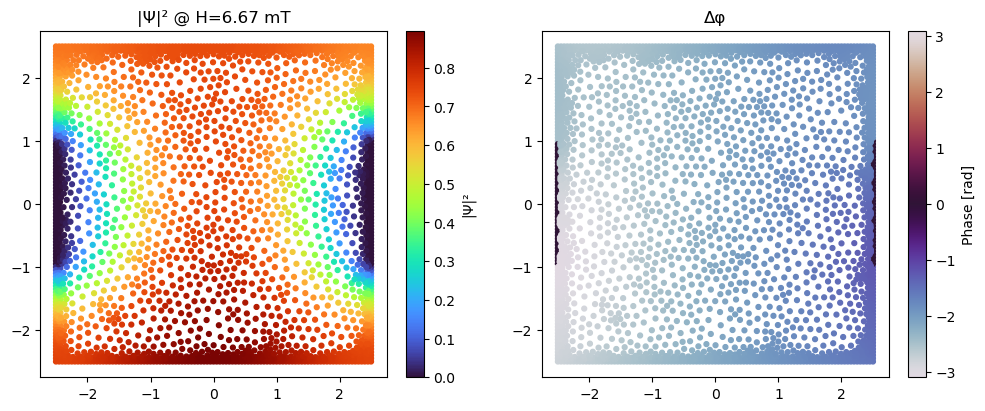

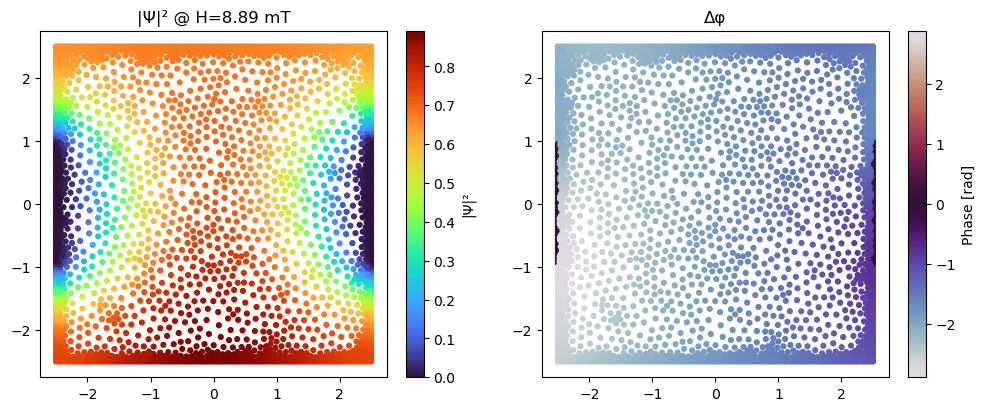

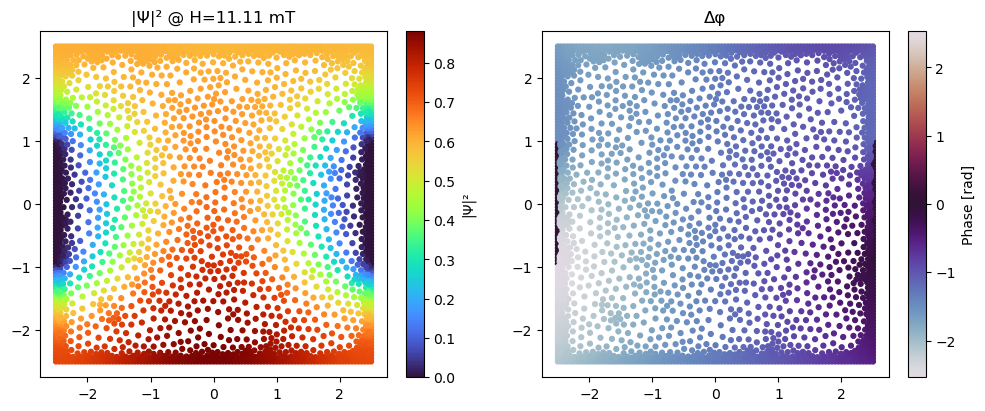

Sin datos de snapshot para H = 13.33 mT; ejecuta la celda anterior.
Sin datos de snapshot para H = 15.56 mT; ejecuta la celda anterior.
Sin datos de snapshot para H = 17.78 mT; ejecuta la celda anterior.
Sin datos de snapshot para H = 20.00 mT; ejecuta la celda anterior.


In [19]:
if not globals().get("snapshot_field_data"):
    raise RuntimeError("Ejecuta la celda anterior para generar o cargar los snapshots.")

for h_value in H_FIELD_VALUES:
    data = snapshot_field_data.get(float(h_value))
    if data is None:
        print(f"Sin datos de snapshot para H = {h_value:.2f} mT; ejecuta la celda anterior.")
        continue

    x_coords = data["x"]
    y_coords = data["y"]
    density_vals = data["density"]
    phase_vals = data["phase"]
    delta_phi = data["delta_phi"]
    mean_density = data.get("mean_density", float(np.mean(density_vals)))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    sc0 = axes[0].scatter(x_coords, y_coords, c=density_vals, s=12, cmap="turbo")
    axes[0].set_title(f"|Ψ|² @ H={h_value:.2f} mT")
    axes[0].set_aspect("equal")
    plt.colorbar(sc0, ax=axes[0], label="|Ψ|²")

    wrapped_phase = np.unwrap(phase_vals)
    sc1 = axes[1].scatter(
        x_coords,
        y_coords,
        c=wrapped_phase,
        s=12,
        cmap="twilight",
        norm=mcolors.CenteredNorm(),
    )
    axes[1].set_title(f"Δφ")
    axes[1].set_aspect("equal")
    plt.colorbar(sc1, ax=axes[1], label="Phase [rad]")
    plt.show()